**Daniel Yu**

Spring 2024

CS 252: Mathematical Data Analysis and Visualization

Project 2: Linear regression

#### Week 2: QR-based linear regression and polynomial regression

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import data
import linear_regression

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Notes

- In your implementations, only the following "high level" `scipy`/`numpy` functions can be used:
    - `np.linalg.inv`
    - `scipy.linalg.lstsq` (in `LinearRegression::linear_regression_scipy` only).
    - `np.linalg.norm`
    - `scipy.linalg.solve_triangular`, 

## Task 4: Implement a QR based linear regression solver

### 4a. QR-decomposition

- Write algorithm to compute QR decomposition (`linear_regression::qr_decomposition`). **Run test code below.** Equation for R: $$R = Q^TA$$
- Implement `linear_regression::linear_regression_qr` to use the QR decomposition to do the linear regression. Recall that the equation is $$Rc = Q^Ty$$ which can be solved without taking the inverse of $R$ through backsolving.

#### Test QR decomposition

In [29]:
iris_filename = 'data/iris.csv'
iris_data = data.Data(iris_filename)

A = iris_data.select_data(['sepal_length', 'petal_width'])
A1 = np.hstack([A, np.ones([len(A), 1])])

lin_reg_qr = linear_regression.LinearRegression(iris_data)
myQ, myR = lin_reg_qr.qr_decomposition(A1)

Q, R = np.linalg.qr(A1)

print(f'Your Q shape is {myQ.shape} and should be {Q.shape}')
print(f'Your R shape is {myR.shape} and should be {R.shape}')
print(f'1st few rows of your Q are\n{myQ[:3]} and should be\n{Q[:3]}')
print('NOTE: It is fine if your Q numbers match in absolute value\nbut 1 or more COLUMNS are negated.')
print(f'\nYour R is\n{myR} and should be\n{R}')
print('NOTE: It is fine if your R numbers match in absolute value\nbut 1 or more ROWS are negated.\n')

Your Q shape is (150, 3) and should be (150, 3)
Your R shape is (3, 3) and should be (3, 3)
1st few rows of your Q are
[[ 0.07056 -0.11765  0.00009]
 [ 0.0678  -0.11202  0.0339 ]
 [ 0.06503 -0.10638  0.06772]] and should be
[[-0.07056 -0.11765 -0.00009]
 [-0.0678  -0.11202 -0.0339 ]
 [-0.06503 -0.10638 -0.06772]]
NOTE: It is fine if your Q numbers match in absolute value
but 1 or more COLUMNS are negated.

Your R is
[[72.27621 15.60873 12.12709]
 [-0.       7.66143 -1.22542]
 [-0.      -0.       1.19668]] and should be
[[-72.27621 -15.60873 -12.12709]
 [  0.        7.66143  -1.22542]
 [  0.        0.       -1.19668]]
NOTE: It is fine if your R numbers match in absolute value
but 1 or more ROWS are negated.



#### Test linear regression via QR decomposition

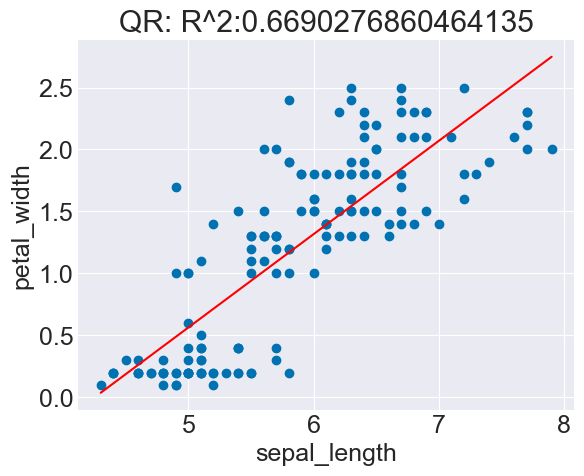

In [33]:
lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'QR:')
lin_reg_qr.scatter('sepal_length', 'petal_width', 'QR:')
lin_reg_qr.show()

**Question 4:** How do your results compare to the built-in SciPy solver? Is this what you expected? Why or why not?

**Answer 4:** They're the same, and that's how they should be. We're not changing anything about the data itself, only the method of obtaining the predicted values. So ideally, the predicted values should be the same no matter what method we're using, and the R^2 values should stay the same, and so should the regression curve.

### Task 4b. Compare performance of the linear regression methods

- In the cell below, load in the brain network `brain.csv` dataset.
- Create `Data` and `LinearRegression` objects.
- Load in the list of variable names in the brain dataset (62)
- Do multiple linear regressions, separately for each of the linear regression methods that you have implemented (including `scipy`): Set all brain data variables except for the last one as the independent variables, the last variable is the depenendent variable.
- Compute and print the mean squared error (MSE) in the predictions made by each linear regression model and the actual y values.

In [34]:
brain_filename = 'data/brain.csv'
brain_data = data.Data(brain_filename)

lin_reg = linear_regression.LinearRegression(brain_data)
headers = list(np.genfromtxt('data/brain_var_names.txt', delimiter = ",", dtype=str))
lin_reg.linear_regression(headers[0:61], headers[61], 'scipy')
print("MSE for scipy: ", lin_reg.compute_mse())

lin_reg.linear_regression(headers[0:61], headers[61], 'qr')
print("MSE for qr: ", lin_reg.compute_mse())

lin_reg.linear_regression(headers[0:61], headers[61], 'normal')
print("MSE for normal: ", lin_reg.compute_mse())


MSE for scipy:  8.668995290464749e-26
MSE for qr:  7.9568718487444475e-25
MSE for normal:  117245.22986180494


**Question 5:** What are the mean squared errors for each of the regression methods on the brain data? Which method(s) do best and which do the worst **and why**?

**Answer 5:** Scipy's MSE is 8.668995290464749e-26, QR's is 7.9568718487444475e-25, and Normal is 117245.22986180494. From the looks of it, Scipy and QR do just as well as they have an extremely low MSE, while Normal is far worse.







## Task 5: Polynomial Regression

We have been creating linear regression fits of form $y =c_0 + c_1x_1 + c_2x_2 + \ldots$, where $x_i$ are independent variables (columns of $A$) and $c_i$ are corresponding coefficients in $c$. However, this equation only allows us to fit data with a line/plane. This may not be the best choice for all datasets.

In this task, you will generalize the linear regression model form to include higher-degree (>1) polynomial terms and explore how this may improve fits to complex data. For example, assume we're doing a simple linear regression with independent variable $x_1$ and dependent variable $y$. A linear regression that fits data with a quadratic shape has the form$$y = c_0 + c_1x_1 + c_2x_1^2$$ 

Complete the following steps to add support for polynomial regression in your `LinearRegression` class.

### 5a. Build the polynomial matrix of the independent variable

The polynomial matrix contains the independent variable raised to a different power in each column. For example, if $A$ originally has a column vector for the independent variable $\vec{x_1}$ ($A = [\vec{x_1}]$) and we wanted to make the above quadratic model, we would append $x_1^2$ ($A = [\vec{x_1}, \vec{x_1^2}]$).

**TODO:**
Implement and test `LinearRegression::make_polynomial_matrix` (*helper method*) that takes care of raising the independent variable samples to different powers.

##### Test `make_polynomial_matrix`

In [5]:
test_A = np.r_[1:10].reshape((9, 1))
test_p = 3

# Test cubic
lin_reg = linear_regression.LinearRegression(data.Data())
print(f'Your polynomial matrix:\n{lin_reg.make_polynomial_matrix(test_A, 3)}')

true_mat = '''
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
'''
print('It should look like:\n', true_mat)

Your polynomial matrix:
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
It should look like:
 
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]



### 5b. Add support for polynomial regression

This can be performed in 3 steps:

1. Implement the `LinearRegression::polynomial_regression` method to perform the polynomial regression (*alternate option: you may instead update your `linear_regression` method. If you decide to go this route, add a keyword argument for the polynomial degree with a default value of 1 to preserve compatability with regular linear regression.*).
    - I suggest using your QR solver, but you could use any of the ones you have implemented.
2. Update `LinearRegression::predict`: Run `make_polynomial_matrix` on the "A" matrix that enters into the computation $y = Ac$ if `self.p > 1`.
3. Add support for plotting polynomials in `LinearRegression::scatter` by generalizing the plotted regression line to a regression polynomial if `self.p > 1`:
    - Getting your polynomial "x" values: Run `make_polynomial_matrix` on your evenly-spaced line sample points. To get the shapes to work out, you may need to add a trailing singleton dimension to your "x" sample points. For example, if you have 1000 "x" sample points, make the shape `(1000, 1)` rather than `(1000,)`.
    - Getting your polynomial "y" values: Use matrix multiplication with your polynomial regression model slopes and/or intercepts.

*There is no explicit test code here — visualizing the fit in the next subtask will help you debug!*

### 5c. Run a polynomial regression

In this subtask, you will debug your polynomial regression implementation and experiment fitting some data with it.

#### Test: Polynomial regression with linear model ($p = 1$)

- In the cell below, fit the `poly_data.csv` dataset using polynomial regression where the polynomial degree $p = 1$. Use your QR solver.
- Use `scatter` to plot the results.
- Print out the mean squared error.

The plot created by running the below cell should "look right" to you.

MSE:  71.81095284569933


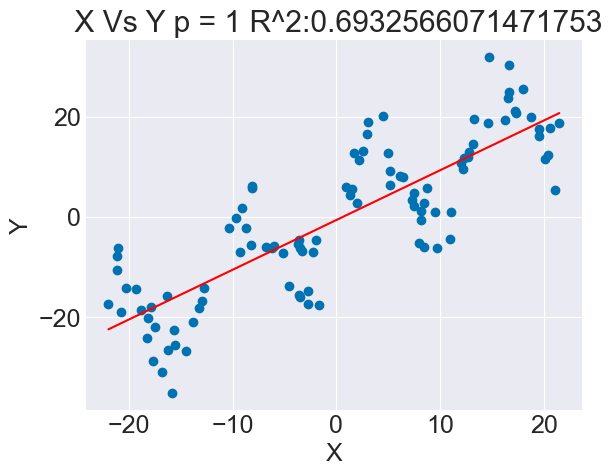

In [35]:
poly_filename = 'data/poly_data.csv'
poly_data = data.Data(poly_filename)
lin_reg_poly = linear_regression.LinearRegression(poly_data)
lin_reg_poly.poly_regression('X', 'Y', 1)
lin_reg_poly.scatter('X', 'Y', ' X Vs Y p = 1')
print("MSE: ", lin_reg_poly.compute_mse())
lin_reg_poly.show()

#### Test: polynomial regression with high degree polynomials

Repeat the steps from the $p = 1$ test above in the cell below, but this time try $p = 15$. 

*Your regression fit should not be a line!*

MSE:  15.929357922922517


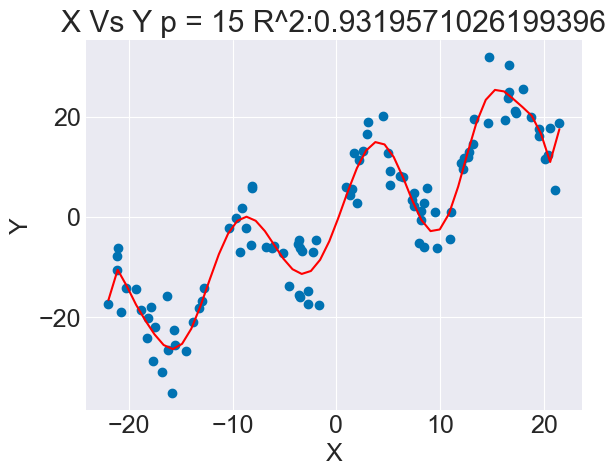

In [36]:
lin_reg_poly2 = linear_regression.LinearRegression(poly_data)
lin_reg_poly2.poly_regression('X', 'Y', 15)
lin_reg_poly2.scatter('X', 'Y', 'X Vs Y p = 15')
print("MSE: ", lin_reg_poly2.compute_mse())
lin_reg_poly2.show()

**Question 6:** Describe the fit compared to `p=1` — is it better or worse? Why?

**Question 7:** Describe what happens visually and in terms of the $R^2$ and MSE values as you experiment with the polynomial degree between 1 and 15.

**Answer 6:** Much better. It looks like the data distribution seems to move in like a sine graph type of way. With more curves, the fit can stretch more out to fit the data.

**Answer 7:** As the polynomial degree increases, so does the amount of curves that the regression curve actually has. The curves in question also get more definition, as in their amplitude increases. This aligns more with the data points, and so the $R^2$ Value gets more closer to 1. I doubt it would be the same if there was new data though.

## Task 6: Overfitting

In this task, you will experiment with how polynomial regression generals to data not used to fit the regression model.

### 6a. Create fit and validation sets

The `poly_data.csv` dataset has 100 samples ($N=100$). In the cell below, split these samples into two separate "datasets" and create 2 `Data` objects representing:
- The first 50% of samples will be used to fit the regression model (i.e. run linear regression on these samples). We will call this the **fit set** (data used to fit the regression).
- The second 50% of samples will be set aside and only used to check how well the fitted regression generalizes to new data. We will call this the **validation set**.

The data samples are already shuffled.

*Hint: There is a helpful `Data` method for paring down a dataset into a certain range of samples.*

In [9]:
poly_data_fit = data.Data(poly_filename)
poly_data_fit.limit_samples(0,50)
poly_data_val = data.Data(poly_filename)
poly_data_val.limit_samples(50,100)
print(poly_data_fit)
print(poly_data_val)

-------------------------------
data/poly_data.csv (50x2)
Headers:
X	Y	
-------------------------------
Showing first 5/50 rows.
2.147	11.382	
9.465	1.034	
4.52	20.251	
1.974	2.89	
-3.358	-6.809	

-------------------------------
data/poly_data.csv (50x2)
Headers:
X	Y	
-------------------------------
Showing first 5/50 rows.
-3.65	-4.658	
9.69	-6.107	
-21.986	-17.271	
-8.694	-2.22	
-15.536	-25.608	



Printing the `Data` object storing the fit set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    -------------------------------
    Showing first 5/50 rows.
    2.147	11.382
    9.465	1.034
    4.52	20.251
    1.974	2.89
    -3.358	-6.809

    -------------------------------

Printing the `Data` object storing the validation set should yield:

    -------------------------------
    data/polydata.csv (50x2)
    Headers:
    X	Y
    -------------------------------
    Showing first 5/50 rows.
    -3.65	-4.658
    9.69	-6.107
    -21.986	-17.271
    -8.694	-2.22
    -15.536	-25.608

    -------------------------------

### 6b. Check fit generalization on validation set

Here is the process for checking how well your fitted linear regression model generalizes to the validation data:
1. Create `Data` objects for both the fit and validation data sets (*as you have already done*).
2. Run linear regression on the fit set.
3. Create a new `LinearRegression` object associated with the validation data.
4. Copy over the fitted slope and intercept coefficients associated with the fit set to the validation set `LinearRegression` object.
5. Create a scatterplot by calling `scatter` to show the validation data and the regression curve that uses the coefficients fitted on the fit dataset (copied over in Step 4).
6. Calculate and report fit statistics (e.g. MSE, $R^2$).

Before doing this, implement the following methods to help you copy over the fitted slope, intercept and other data from your fit set `LinearRegression` object:

- `get_fitted_slope`: return the fitted regression slopes.
- `get_fitted_intercept`: return the fitted regression intercept.
- `initialize(ind_vars, dep_var, slope, intercept, p)`: set fields based on passed in parameter values.

#### Check overfitting with $p = 15$ polynomial regression model

In the cell below:

1. Fit a polynomial regression model with $p = 15$ on the fit set.
2. Create 2 scatter plots:
    - Showing the fit set and regression curve fitted to it.
    - Showing the validation set and regression curve that uses the fitted coefficients to the **fit set**.
3. Compute and print the MSE for both the fit and validation sets.

Use the 6 step process above to guide you through the setup.

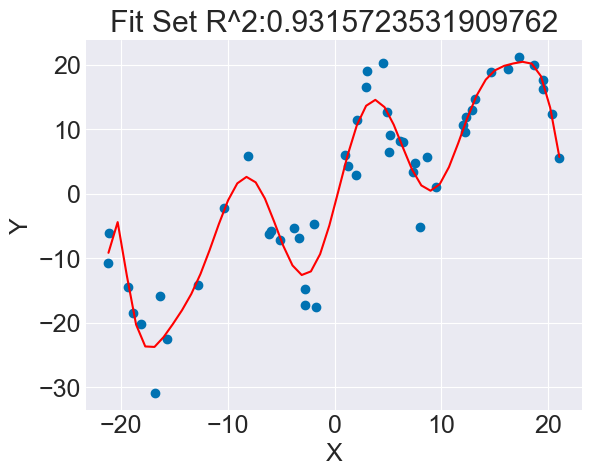

MSE for fitset:  11.996174447004918


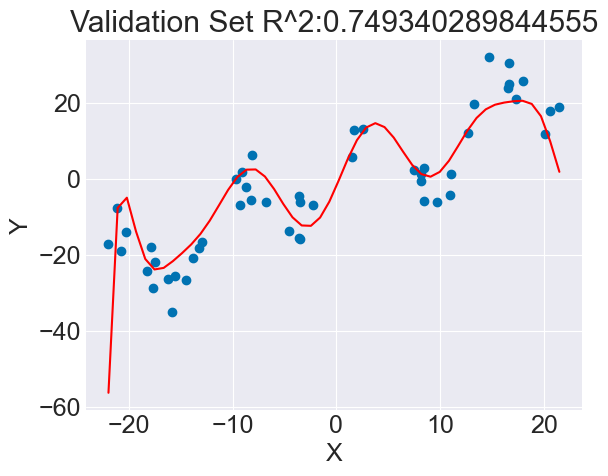

MSE for validation set:  70.80321634920745


In [37]:
lin_reg_poly_fit = linear_regression.LinearRegression(poly_data_fit)
lin_reg_poly_fit.poly_regression('X', 'Y', 15)

lin_reg_poly_val = linear_regression.LinearRegression(poly_data_val)

lin_reg_poly_val.initialize('X','Y',slope = lin_reg_poly_fit.get_fitted_slope(), intercept = lin_reg_poly_fit.get_fitted_intercept(), p=15)

lin_reg_poly_fit.scatter("X", "Y", 'Fit Set')
lin_reg_poly_fit.show()
print("MSE for fitset: ", lin_reg_poly_fit.compute_mse())

lin_reg_poly_val.scatter("X", "Y", 'Validation Set')
lin_reg_poly_val.show()
print("MSE for validation set: ", lin_reg_poly_val.compute_mse())

**Question 8:** Describe how the fitted coefficients obtained for the fit set generalize to the validation set. Do they do a good or bad job? Why?

**Question 9:** Does the generalization improve or worsen for polynomial degrees < 15? Are Back up your observations with numbers (e.g. MSE).

**Question 10:** Are there any values/ranges of polynomial degrees that generalize acceptably to the validation set? Why do you think so?

**Question 11:** What happens when you increase the polynomial degree much above 15? Why do you think this happens? Back up your observations with numbers (e.g. MSE).

**Answer 8:** The fitted coefficients obtained for the fit generalized to the validation set did a bad job as a result of causing the residuals to become even bigger, resulting in a r^2 to be closer to 0 and the MSE to be very high. 

**Answer 9:** The generalization worsens for polynomial degrees < 15, as the MSE error gets bigger, for instance for the validation set, when p = 15, the MSE is 70.80, but when p = 3 the MSE is 93.01736. Additionally, the r^2 decreases, as when p = 15, the r^2 value is 0.75 when the p = 3 the r^2 value is 0.67.

**Answer 10:** The range of polynomial degrees that generalize acceptably to the validation set would be 10-15, as a result of being values that although will give us somewhat high error, offers much better generalization.

**Answer 11:** When the polynomial degree reaches above 15, the plot is more susceptible to overfitting, as we are trying to fit data with high degree polynomials. As a result the MSE is very large, for instance, when p = 80, the MSE is 10412155405 for validation set.

## Extensions

### a. Reminder: AI Policy

The goal of extensions is to learn and create something new beyond the base project that excites you. To serve this goal and out of fairness to your hardworking classmates, **AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions.** This includes both written analysis, plotting, and code. We will only grade **your** work, not an AI's. **We will stop grading your project if we notice AI-generated content (to any capacity).**

### b. Guidelines

To receive credit for any extension, you must:
1. Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
2. **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
3. Include (*labeled!*) plots and/or numbers to present your results.
4. Write up your extensions below or in a separate notebook.
5. Give kudos to all sources, including anyone that you consulted.

### c. Suggestions

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

The ideas below are **suggested** extensions — feel free to go in another direction related to this project that is not listed!

### 1. Your own data

- Run linear regression on datasets that interest you. Identify your hypotheses about the association between variables and test them out. Make plots and report all relevant metrics fit.

### 2. Linear regression algorithm comparison

- Compare the linear regression methods that you implemented on a dataset of your choice.
- Research and implement matrix condition number. Find a dataset with a poor matrix condition number and then compare the regression methods. Which does best and why?

### 3. Confidence intervals or other kinds of error bars on linear regression plots

- Add the option to plot 95% confidence intervals on the linear regression predictions in your plot functions (e.g. `scatter`). [This website](https://real-statistics.com/regression/confidence-and-prediction-intervals/) should be a helpful reference.

### 4. Overfitting

- Run polynomial regression on other datasets. What degree polynomial works well? When do you overfit?

### 5. Stepwise linear regression

- Implement the stepwise linear regression discussed in class where you add variables to the regression model one-by-one in a greedy fashion: each variable added out of the available ones not already entered in the regression should result in the largest increase in the adjusted $R^2$ value on the validation data.

# PART 1: OBSERVING OTHER REGRESSIONS

<b>I found this dataset on characteristics of people and how much time they spend on social media, so I wanted to see if I would be able to see if there's an association between age and amount of time spent on social media, and predict future values.<b>

### Hypothesis: ###

As we get older to our teenage years, there should be a spike in social media usage, but slowly fall as we turn to our more adult years. I'd imagine that the elderly or babies are too fond of technology, so there should be some kind of Beizer Curve. A rise in time spent, and then a decay.

MSE for Weight vs. Height:  6.426796628087134


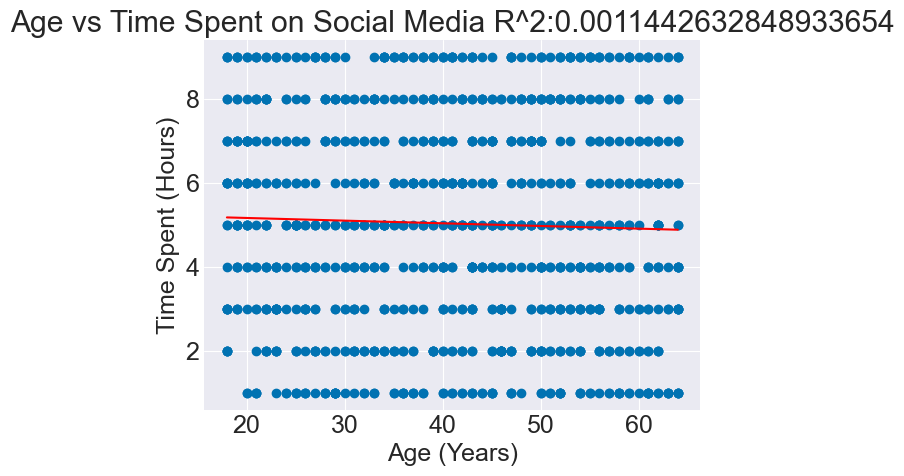

In [11]:
tech_filename = 'data/dummy_data.csv'
tech_set = data.Data(tech_filename)
lin_reg_tech = linear_regression.LinearRegression(tech_set)
lin_reg_tech.linear_regression(['age'], 'time_spent')
lin_reg_tech.scatter('age', 'time_spent', 'Age vs Time Spent on Social Media')
plt.xlabel('Age (Years)')
plt.ylabel('Time Spent (Hours)')
print("MSE for Weight vs. Height: ", lin_reg_tech.compute_mse())

Oooook then, that didn't work at all. Looks like there's an age that uses at least every time frame. So ther'es social media addicts and non users all across the ages. But that's okay! Sometimes there is no correlation between anything. Let's try another data set.

<b>Here I wanted to find a possible association of a video game's rating and it's projected amount of sales. Or, if there's a better correlation between global sales and the critic score or user score.<b>

Annoyingly, there's blank spaces and quotes in this CSV file, so we're going to have to need help from the old improved_data file. We're also going to add a little case in the data file to ignore blank spaces, because that messes with the regression quite a bit.

### Hypothesis 2: ###
The higher rated the game, the more sales it should get. People should be preferring games that are better rated. They would also value critic scores more than user scores (even though user scores are a better evaluation in my opinion)

For the sake of readibility, we're going to reduce the sample count to a low number.

MSE for Critic Score vs. Global Sales:  1.4652761316721714


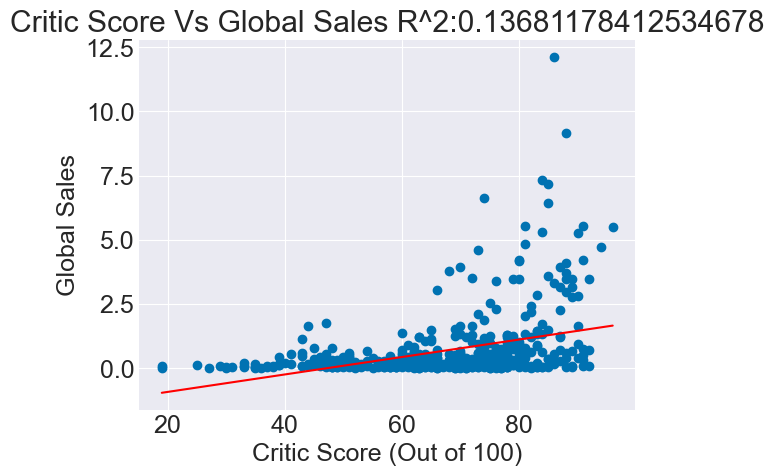

In [12]:
game_filename = 'data/Cleaned Data 2.csv'

import data_improved
from data_improved import Data2
game_set = data_improved.Data2(game_filename)
game_set.limit_samples(0,500)

# print(game_set.select_data(['Critic_Score']))

lin_reg_game = linear_regression.LinearRegression(game_set)
lin_reg_game.linear_regression(['Critic_Score'], 'Global_Sales')
lin_reg_game.scatter('Critic_Score', 'Global_Sales', 'Critic Score Vs Global Sales')
plt.xlabel('Critic Score (Out of 100)')
plt.ylabel('Global Sales')
print("MSE for Critic Score vs. Global Sales: ", lin_reg_game.compute_mse())


Looks like there's more of a non-linear correlation than a linear one, let's replot it with a different degree.

MSE for Critic Score vs. Global Sales:  1.3043253577028509


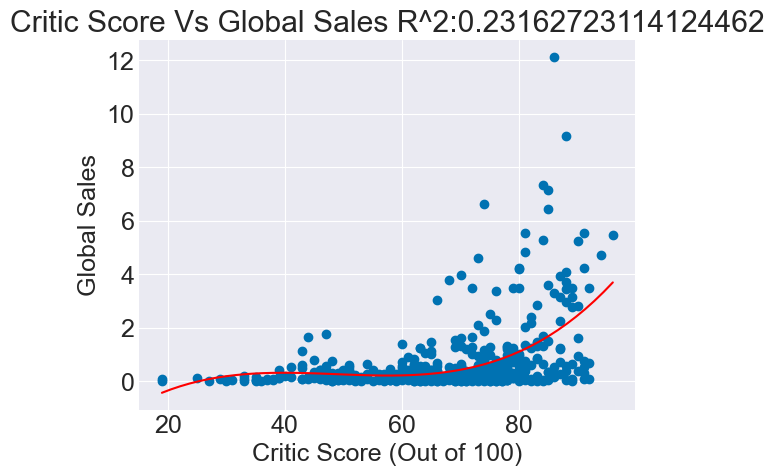

In [13]:
lin_reg_game.poly_regression('Critic_Score', 'Global_Sales', 3)
lin_reg_game.scatter('Critic_Score', 'Global_Sales', 'Critic Score Vs Global Sales')
plt.xlabel('Critic Score (Out of 100)')
plt.ylabel('Global Sales')
print("MSE for Critic Score vs. Global Sales: ", lin_reg_game.compute_mse())

Not much of a change in the R squared as expected, but perhaps there is a better correlation between User Scores instead of Critic Scores?

MSE for User Score vs. Global Sales:  1.6409297646391492


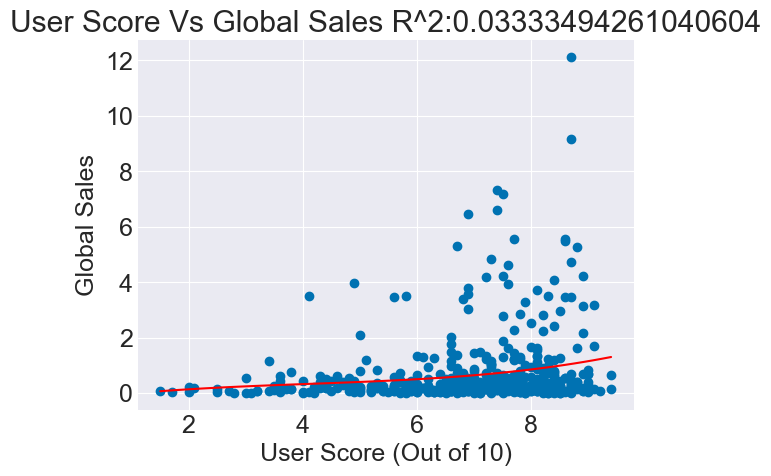

In [13]:
lin_reg_game.poly_regression('User_Score', 'Global_Sales', 3)
lin_reg_game.scatter('User_Score', 'Global_Sales', 'User Score Vs Global Sales')
plt.xlabel('User Score (Out of 10)')
plt.ylabel('Global Sales')
print("MSE for User Score vs. Global Sales: ", lin_reg_game.compute_mse())

Even worse, looks like sales are more likely to depend on critic ratings than user ratings.

How about the correlation between <b>User Scores and Critic Scores?<b> Do they agree? In some instances they can disagree, but how often is that the case?

MSE for User Score vs. Critic Score:  125.63465295718352


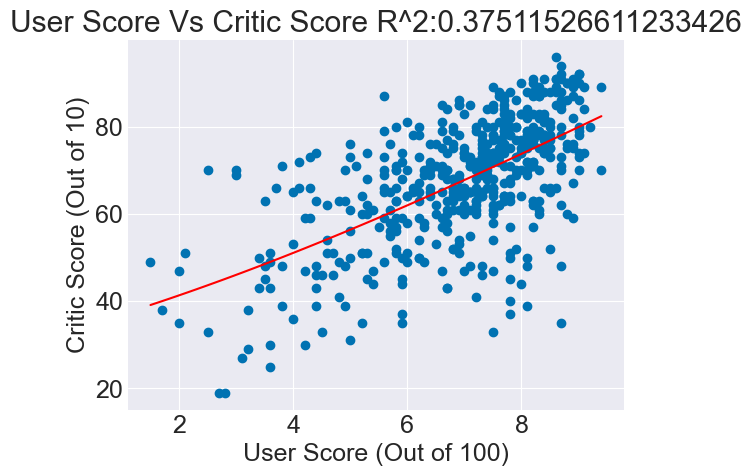

In [28]:
lin_reg_game.poly_regression('User_Score', 'Critic_Score', 3)
lin_reg_game.scatter('User_Score', 'Critic_Score', 'User Score Vs Critic Score')
plt.xlabel('User Score (Out of 100)')
plt.ylabel('Critic Score (Out of 10)')
print("MSE for User Score vs. Critic Score: ", lin_reg_game.compute_mse())

Not as strong as expected either, but a much higher correlation than the last 2 graphs. 
## Takeaway ##
There is a slight positive trend between ratings and scores, though it isn't as direct as it may seem, it seems highly unlikely to be able to predict a game's sales based on the rating, especially when its higher. Which is a little unfortunate, as it makes sales seem more like sales if anything. It also seems like critics and users generally agree on their ratings, but not so much. All R^2 Values are all less than .5, so the regression isn't that much.

# PART 2: MSEs & Matrix Condition Numbers

We're going to move on to a dataset that has a little less unpredictibility. Here's one that should show the relationship between the time a student studies in hours to the amount of marks they get on a test. There should be a pretty strong positive correlation between the two, as the more you study, the more knowledge you absorb.

MSE for Time Studied Vs # of Marks:  8.94709315297289


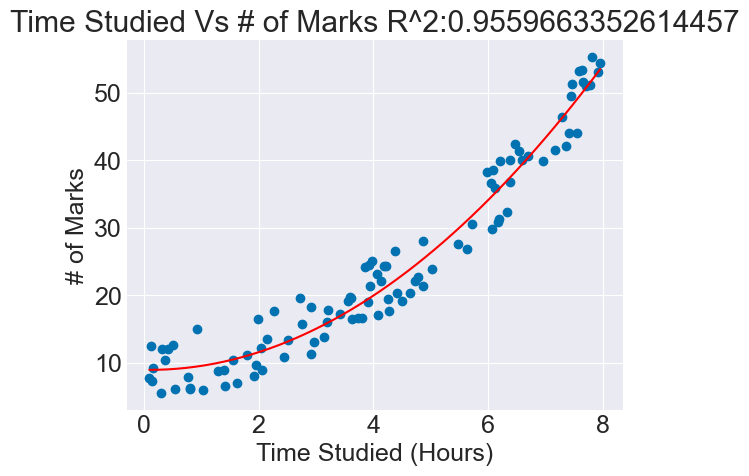

In [15]:
mark_filename = 'data/Student_Marks.csv'
mark_set = data_improved.Data2(mark_filename)
mark_set.limit_samples(0,500)
lin_reg_mark = linear_regression.LinearRegression(mark_set)
lin_reg_mark.poly_regression('time_study', 'Marks', 2)
lin_reg_mark.scatter('time_study', 'Marks', 'Time Studied Vs # of Marks')
plt.xlabel('Time Studied (Hours)')
plt.ylabel('# of Marks')
print("MSE for Time Studied Vs # of Marks: ", lin_reg_mark.compute_mse())

Makes sense, and it looks there's a pretty highly correlated regression curve as well! More so if there's a second degree anyways. It seems like the MSE is a little high, wonder if it would change if we found the predicted values through a different method?

In [16]:
lin_reg_mark = linear_regression.LinearRegression(mark_set)
lin_reg_mark.linear_regression(['time_study'], 'Marks', 'scipy')
print("MSE for scipy: ", lin_reg_mark.compute_mse())

lin_reg_mark.linear_regression(['time_study'], 'Marks', 'qr')
print("MSE for qr: ", lin_reg_mark.compute_mse())

lin_reg_mark.linear_regression(['time_study'], 'Marks', 'normal')
print("MSE for normal: ", lin_reg_mark.compute_mse())

MSE for scipy:  22.789030971957633
MSE for qr:  22.78903097195764
MSE for normal:  22.789030971957633


Aside for the tiniest decimal difference, not at all! Let's try this with one of our earlier datasets:

In [17]:
lin_reg_game = linear_regression.LinearRegression(game_set)
lin_reg_game.linear_regression(['Critic_Score'], 'Global_Sales', 'scipy')
print("MSE for scipy: ", lin_reg_game.compute_mse())

lin_reg_game.linear_regression(['Critic_Score'], 'Global_Sales', 'qr')
print("MSE for qr: ", lin_reg_game.compute_mse())

lin_reg_game.linear_regression(['Critic_Score'], 'Global_Sales', 'normal')
print("MSE for normal: ", lin_reg_game.compute_mse())

MSE for scipy:  1.4652761316721714
MSE for qr:  1.4652761316721714
MSE for normal:  1.4652761316721714


All these are exactly the same!

Upon research, I learned that a matrix condition number measures the sensitivity of a function in terms of changes and errors from the input. Additionally, how much of the errors in output come from the error in the input. Therefore, a low condition number represents the matrix to be well-conditioned, while a matrix with high condition number signifies the matrix to be ill-conditioned - for small changes in inputs, large change in the dependent variable. The matrix condition number can be demonstrated using numpy's provided method: numpy.linalg.cond. So let's see how this looks!

In [18]:
# Don't run this this is just a method
def get_matrixnumber(self, ind_vars, dep_var):
        '''
        returns the matrix condition number
        '''
        self.A = self.data.select_data(ind_vars)
        self.y = self.data.select_data([dep_var])
        self.A = np.hstack([np.ones([self.A.shape[0], 1]), self.A])
        return np.linalg.cond(self.A)

In [18]:
print(lin_reg_mark.get_matrixnumber(['time_study'], 'Marks'))

9.722341375856582


How about in comparison to Game Ratings?

In [19]:
print(lin_reg_game.get_matrixnumber(['Critic_Score'], 'Global_Sales'))

336.2829001159692


Makes sense, we can see that the variability is much greater in the game data than the mark data.

# PART 3: SHOWING ERROR

We know that regression curves aren't perfect, in fact most of the time they have an insane amount of error. I wanted to see if I could better visualize the error in data points. 

I decided to implement error bars on a linear regression plot as well as experiment with a plt function fill_between. To implement the error bars, I used matplotlib's error bar function, which took in parameters of x,y, the error, and a color. 

To find the error of the data, I looked to make a 95% confidence interval using this formula:

$$CI = \bar{x} \pm z \frac{s}{\sqrt{n}}$$

where $\bar{x}$ is the sample mean, $z$ is the confidence level value, which for 95% is 1.96, $s$ is the sample standard deviation, and $n$ is the sample size.

That is implemented as such:

In [20]:
ci = 1.96 * np.std(y)/np.sqrt(len(x))

So let's see how this looks!

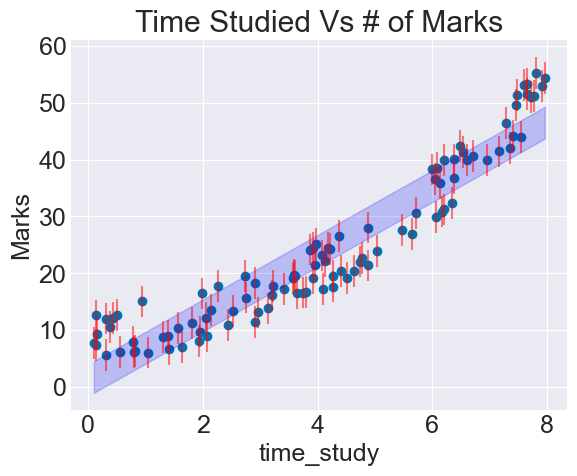

In [21]:
lin_reg_mark = linear_regression.LinearRegression(mark_set)
lin_reg_mark.linear_regression(['time_study'], 'Marks')
lin_reg_mark.scatter2('time_study', 'Marks', 'Time Studied Vs # of Marks', 'true', 'true','false')

I've also implemented 3 extra booleans to the scatter method, so you can toggle whether you only want to see error bars, error region, or regression line, or any combination of the 3!

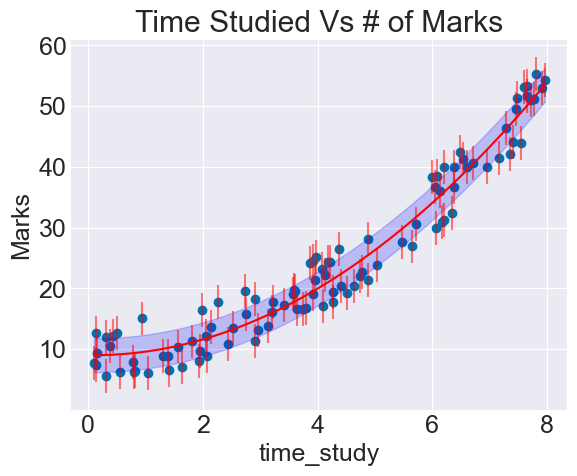

In [22]:
lin_reg_mark.poly_regression('time_study', 'Marks', 2)
lin_reg_mark.scatter2('time_study', 'Marks', 'Time Studied Vs # of Marks', 'true', 'true', 'true')

I've also made it compatible for non linear regression curves!

# BONUS: SHOWING ERROR BARS PROPERLY

This isn't really how error bars work, are they? They're more so to show the variance in y values at specific x points. The condition for this is that they have to share x Values! So let's revisit our iris dataset to visualize it in a different way! (Because that dataset has multiple y values at x datapoints)

So here's what this new, third "scatter" method does:

1. For every X Value, the method stores every Y Value it has in a dictionary
2. For each dictionary, it will calculate the mean and confidence interval seperately
3. Plot each X value in a list, and for Y the X value's respective mean, with the error bars being it's rspective confidence interval.

Let's see that in action!

Here is the original graph for reference:

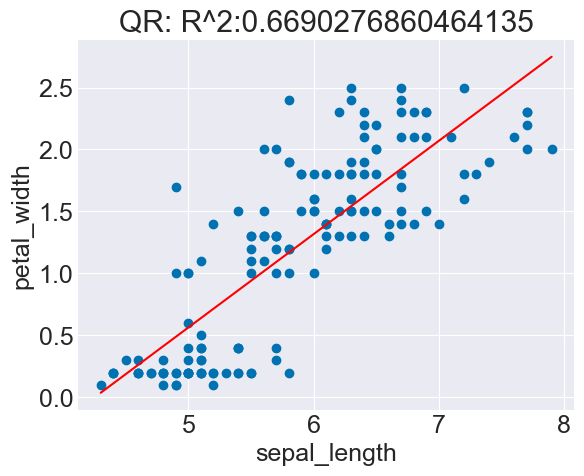

In [38]:
lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'QR:')
lin_reg_qr.scatter('sepal_length', 'petal_width', 'QR:')
lin_reg_qr.show()

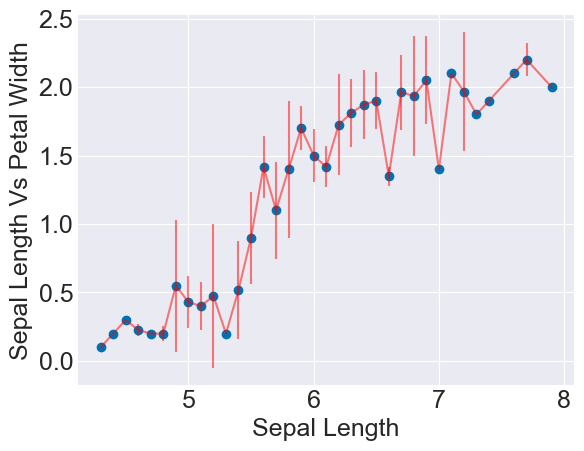

In [68]:
iris_filename = 'data/iris.csv'
iris_data = data.Data(iris_filename)
lin_reg_qr = linear_regression.LinearRegression(iris_data)
lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'qr')
plt.xlabel('Sepal Length')
plt.ylabel('Petal Width')
plt.ylabel('Sepal Length Vs Petal Width')
lin_reg_qr.scatter3('sepal_length', 'petal_width', 'false', 'true')
lin_reg_qr.show()

Now we can see the 95% Confidence interval for each Sepal Length! (It's good to know that some of these intervals aren't accurate because some points only have 1 data point, so this grpah in the end isn't that useful...)

You can also toggle the error region to show here!

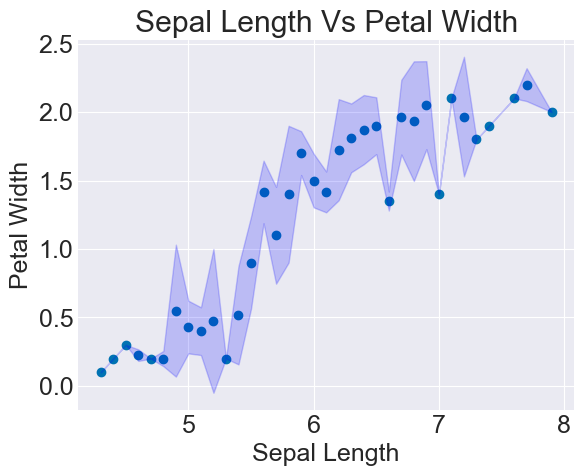

In [24]:
iris_filename = 'data/iris.csv'
iris_data = data.Data(iris_filename)
lin_reg_qr = linear_regression.LinearRegression(iris_data)
lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'qr')
plt.xlabel('Sepal Length')
plt.ylabel('Petal Width')
plt.title('Sepal Length Vs Petal Width')
lin_reg_qr.scatter3('sepal_length', 'petal_width', 'true', 'false')
lin_reg_qr.show()

Obviously, this is pretty ugly to look at. Most error regions are pretty smooth and look like they could be their own curve. That's largly because of all the samples that are contained within it, so if we were to examine something that had a lot of samples on every possible x value, we would get something much smoother. That's why we have some points with no error region about it, as there are only points with that value and you can't make an error bound around one data point.

# KUDOS

Of course, thanks to the Professor and TAs for troubleshooting the entire process, and also checking if my work was okay, because there was a lot of examining required!